<a href="https://colab.research.google.com/github/samsyano/Microsoft-Capstone-AI-Challenge/blob/master/appliance_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAT264x - 2 inputs network implementation

## Download and extract data

In [1]:
!wget https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/19/public/data-release.zip

!unzip -o data-release.zip

--2020-03-13 02:26:15--  https://mpp0xc0ae45ef.blob.core.windows.net/drivendata-mpp-storage/data/19/public/data-release.zip
Resolving mpp0xc0ae45ef.blob.core.windows.net (mpp0xc0ae45ef.blob.core.windows.net)... 52.239.154.100
Connecting to mpp0xc0ae45ef.blob.core.windows.net (mpp0xc0ae45ef.blob.core.windows.net)|52.239.154.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30080041 (29M) [application/zip]
Saving to: ‘data-release.zip’

data-release.zip    100%[===================>]  28.69M  11.5MB/s    in 2.5s    

2020-03-13 02:26:24 (11.5 MB/s) - ‘data-release.zip’ saved [30080041/30080041]

Archive:  data-release.zip
  inflating: train_labels.csv        
   creating: test/
  inflating: test/1677_v.png         
  inflating: test/1795_c.png         
  inflating: test/1632_v.png         
  inflating: test/1919_v.png         
  inflating: test/1806_c.png         
  inflating: test/1576_v.png         
  inflating: test/1843_c.png         
  inflating: test/1768

## Import dependencies

In [2]:
import pandas as pd
import numpy as np
from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

import keras
from keras import optimizers
from keras.utils import to_categorical
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Using TensorFlow backend.


## Read data

In [3]:
train_df = pd.read_csv('train_labels.csv', index_col=0)

train_df['current_file'] = train_df.index.map(lambda id: f'train/{id}_c.png')
train_df['voltage_file'] = train_df.index.map(lambda id: f'train/{id}_v.png')

print(train_df.head())

      appliance      current_file      voltage_file
id                                                 
1000          4  train/1000_c.png  train/1000_v.png
1001          9  train/1001_c.png  train/1001_v.png
1002          4  train/1002_c.png  train/1002_v.png
1003          9  train/1003_c.png  train/1003_v.png
1004          6  train/1004_c.png  train/1004_v.png


In [0]:
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels):
  """
  Reads the spectogram files from disk and normalizes the pixel values
    @params:
      file_paths - Array of file paths to read from
      img_rows - The image height.
      img_cols - The image width.
      as_grey - Read the image as Greyscale or RGB.
      channels - Number of channels.
    @returns:
      The created and compiled model (Model)        
  """
  images = []
  
  for file_path in file_paths:
    images.append(imread(file_path, as_gray = as_gray))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / np.max(images)
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images

### Parameters

In [0]:
as_gray = True
in_channel = 4

if as_gray:
  in_channel = 1

img_rows, img_cols = 128, 176
num_classes = 11 # number of appliances

batch_size = 32
epochs = 100
input_shape = (img_rows, img_cols, in_channel)
input_img = Input(shape = input_shape)

### Current files

In [0]:
x_train_current = read_spectograms(train_df.current_file.values, img_rows, img_cols, as_gray, in_channel)

### Voltage files

In [0]:
x_train_voltage = read_spectograms(train_df.voltage_file.values, img_rows, img_cols, as_gray, in_channel)

### Labels

In [0]:
labels = train_df.appliance.values

# convert class vectors to binary class matrices One Hot Encoding
labels = keras.utils.to_categorical(labels, num_classes)

## Show data

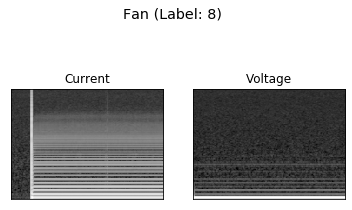

In [24]:
appliances = [
    'Compact Fluorescent Lamp', 
    'Hairdryer', 
    'Microwave', 
    'Air Conditioner', 
    'Fridge', 
    'Laptop', 
    'Vacuum', 
    'Incandescent Light Bulb', 
    'Fan',
    'Washing Machine',
    'Heater'
]

# pick a random index from the list
rn_appliance = np.random.choice(train_df.appliance.values)
rn_label = train_df.appliance.values[rn_appliance]
rn_current = x_train_current[rn_appliance]
rn_voltage = x_train_voltage[rn_appliance]

plt.figure()
plt.axis('off')

plt.suptitle(f"{appliances[rn_label]} (Label: {rn_label})", fontsize="x-large")

plt.subplot(121)
curr_img = None
if as_gray:
  curr_img = np.reshape(rn_current, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_current, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Current")
plt.xticks([])
plt.yticks([])

plt.subplot(122)
if as_gray:
  curr_img = np.reshape(rn_voltage, (img_rows, img_cols))
else:
  curr_img = np.reshape(rn_voltage, (img_rows, img_cols, in_channel))

plt.imshow(curr_img, cmap='gray')
plt.title("Voltage")
plt.xticks([])
plt.yticks([])
plt.show()

## Create and train the model

### Split in train and test batches

In [0]:
# stack so we can split on the same pair of images
x_train_comp = np.stack((x_train_current, x_train_voltage), axis=4)

x_train, x_test, y_train, y_test = train_test_split(x_train_comp, labels, test_size = 0.3, random_state=666)

# take them apart
x_train_current = x_train[:,:,:,:,0]
x_test_current = x_test[:,:,:,:,0]

x_train_voltage = x_train[:,:,:,:,1]
x_test_voltage = x_test[:,:,:,:,1]

### Create the model

In [0]:
def create_convolution_layers(input_img):
  model = Conv2D(32, (3, 3), padding='same', input_shape=input_shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
  
  model = Conv2D(64, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.25)(model)
    
  model = Conv2D(128, (3, 3), padding='same')(model)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  model = Dropout(0.4)(model)
    
  # model = Conv2D(128, (3, 3), padding='same')(model)
  # model = LeakyReLU(alpha=0.1)(model)
  # model = MaxPooling2D(pool_size=(2, 2),padding='same')(model)
  # model = Dropout(0.4)(model)
  return model

In [27]:
current_input = Input(shape=input_shape)
current_model = create_convolution_layers(current_input)

voltage_input = Input(shape=input_shape)
voltage_model = create_convolution_layers(voltage_input)

conv = concatenate([current_model, voltage_model])

conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation='softmax')(dense)

model = Model(inputs=[current_input, voltage_input], outputs=[output])

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 176, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 176, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 176, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 176, 32) 320         input_

### Train the model

In [28]:
best_weights_file="weights.best.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#lr_reducer = ReduceLROnPlateau(verbose=1)

callbacks = [checkpoint]

model.fit([x_train_current, x_train_voltage], y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          verbose=1,
          validation_data=([x_test_current, x_test_voltage], y_test),
          shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 403 samples, validate on 173 samples
Epoch 1/100





403/403 [==============================] - 18s 44ms/step - loss: 3.2448 - acc: 0.2531 - val_loss: 1.9659 - val_acc: 0.3642

Epoch 00001: val_acc improved from -inf to 0.36416, saving model to weights.best.hdf5
Epoch 2/100
403/403 [==============================] - 2s 5ms/step - loss: 1.6342 - acc: 0.4739 - val_loss: 1.5420 - val_acc: 0.5549

Epoch 00002: val_acc improved from 0.36416 to 0.55491, saving model to weights.best.hdf5
Epoch 3/100
403/403 [==============================] - 2s 5ms/step - loss: 1.3230 - acc: 0.5806 - val_loss: 1.2631 - val_acc: 0.6243

Epoch 00003: val_acc improved from 0.55491 to 0.62428, saving model to weights.best.hdf5
Epoch 4/100
403/403 [==============================] - 2s 5ms/step - loss: 1.1024 - acc: 0.6303 - val_loss: 1.1772 - val_acc: 0.6416

Epoch 00004: val_acc improved from 0.62428 to 0.64

### Basic evaluation

In [29]:
# load weights
model.load_weights(best_weights_file)

final_loss, final_acc = model.evaluate([x_test_current, x_test_voltage], y_test, verbose=1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))  

173/173 [==============================] - 0s 1ms/step
Final loss: 0.470359, final accuracy: 0.907514


## Predict

In [30]:
predict_df = pd.read_csv('submission_format.csv', index_col=0)

predict_df['current_file'] = predict_df.index.map(lambda id: f'test/{id}_c.png')
predict_df['voltage_file'] = predict_df.index.map(lambda id: f'test/{id}_v.png')

x_test_current = read_spectograms(predict_df.current_file.values, img_rows, img_cols, as_gray, in_channel)
x_test_voltage = read_spectograms(predict_df.voltage_file.values, img_rows, img_cols, as_gray, in_channel)

predict_df.head()

,appliance,current_file,voltage_file
id,,,
1576,0,test/1576_c.png,test/1576_v.png
1577,0,test/1577_c.png,test/1577_v.png
1578,0,test/1578_c.png,test/1578_v.png
1579,0,test/1579_c.png,test/1579_v.png
1580,0,test/1580_c.png,test/1580_v.png


In [0]:
#get the predictions for the test data
predicted_classes = model.predict([x_test_current, x_test_voltage])

predict_df.appliance = np.argmax(predicted_classes,axis=1)

predict_df = predict_df.drop(['current_file', 'voltage_file'], axis=1)

predict_df.to_csv('submission_1.csv')

from google.colab import files

files.download('submission_1.csv')